# 0.0 Imports

In [1]:
!pip install inflection
!pip install boruta
!pip install tabulate

In [2]:
import inflection
import math
import matplotlib

import matplotlib.pyplot   as plt
import matplotlib.gridspec as gs
import numpy               as np
import pandas              as pd
import seaborn             as sns
import xgboost             as xgb

from boruta                import BorutaPy
from datetime              import datetime, timedelta, date
from IPython.core.display  import HTML
from IPython.display       import Image
from scipy                 import stats as ss
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression,Lasso
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from tabulate              import tabulate

## 0.1 Helper functions

In [65]:
def cramer_v (a,b):
    cm = pd.crosstab(a, b).values
    
    n = cm.sum()
    k,r = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))

def mean_absolute_percentage_error (y,yhat):
    return np.mean(np.abs((y-yhat)/y))

def ml_error (model_name, y, yhat):
    mae = mean_absolute_error(y,yhat)
    mape = mean_absolute_percentage_error(y,yhat)
    rmse = np.sqrt(mean_squared_error(y,yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': rmse}, index=[0])

def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1,kfold+1)):
      if verbose:
        print('\nKFold Number: {}'.format(k))
            
      #start and end date for validation
      validation_start_date = x_training['date'].max() - timedelta(days=k*6*7)
      validation_end_date = x_training['date'].max() - timedelta(days=(k-1)*6*7)
    
      #filtering dataset
      training = x_training[x_training['date'] < validation_start_date]
      validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]
    
      #training and validation dataset
      #training
      xtraining = training.drop(['date','sales'],axis=1)
      ytraining = training['sales']
    
      #validation
      xvalidation = validation.drop(['date','sales'],axis=1)
      yvalidation = validation['sales']
    
      #model
      m = model.fit(xtraining, ytraining)

      #prediction
      yhat = m.predict(xvalidation)
    
      #performance
      m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
    
      #store performance of each kfold iteration
      mae_list.append(m_result['MAE'])
      mape_list.append(m_result['MAPE'])
      rmse_list.append(m_result['RMSE'])
    
    return pd.DataFrame({'MAE CV': [np.round(np.mean(mae_list),2).astype(str) + ' +/- ' + np.round(np.std(mae_list),2).astype(str)],
                         'MAPE CV': [np.round(np.mean(mape_list),2).astype(str) + ' +/- ' + np.round(np.std(mape_list),2).astype(str)],
                         'RMSE CV': [np.round(np.mean(rmse_list),2).astype(str) + ' +/- ' + np.round(np.std(rmse_list),2).astype(str)]
                         })

## 0.2 Loading Data

In [4]:
df_store_raw = pd.read_csv('store.csv', low_memory=False)
df_sales_raw = pd.read_csv('train.csv', low_memory=False)

#merge
df_raw = pd.merge(df_store_raw,df_sales_raw,how='left',on='Store')

# 1.0 Descrição dos Dados

In [5]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [6]:
cols_old = ['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'DayOfWeek',
       'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday']

sneakcase = lambda x: inflection.underscore (x)

cols_new = list(map(sneakcase,cols_old))

df1.columns = cols_new

## 1.2 Data Dimensions

In [7]:
print('Number of columns:', format(df1.shape[1]))
print('Number of rows:', format(df1.shape[0]))

Number of columns: 18
Number of rows: 1017209


## 1.3 Data types

In [8]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
dtype: object

## 1.4 Check NA

In [9]:
df1.isna().sum()

store                                0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
dtype: int64

## 1.5 Fillout NA

In [10]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan (x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan (x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan (x['promo2_since_week']) else x['promo2_since_week'],axis=1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan (x['promo2_since_year']) else x['promo2_since_year'],axis=1)

#promo_interval
month_map = {1: 'Jan', 2:'Fev', 3:'Mar', 4:'Abr', 5:'May', 6:'Jun', 7:'Jul', 8:'Ago', 9:'Set', 10:'Oct', 11:'Nov', 12:'Dec'}

df1['promo_interval'].fillna(0,inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

## 1.6 Change Types

In [11]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

## 1.7 Descriptive Statistical

In [12]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [13]:
#central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(min)).T
d2 = pd.DataFrame(num_attributes.apply(max)).T
d3 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d4 = pd.DataFrame(num_attributes.apply(np.std)).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenate
m = pd.concat([d1,d2,d3,ct1,ct2,d4,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
2,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
3,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304
4,promo2,0.0,1.0,1.0,0.500564,1.0,0.500000,-0.002255,-1.999999
5,promo2_since_week,1.0,52.0,51.0,23.619033,22.0,14.310057,0.178723,-1.184046
6,promo2_since_year,2009.0,2015.0,6.0,2012.793297,2013.0,1.662657,-0.784436,-0.210075
7,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
8,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
9,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773


### 1.7.2 Categorical Attributes

In [14]:
cat_attributes.apply(lambda x: x.unique().shape[0])

store_type         4
assortment         3
promo_interval     4
state_holiday      4
month_map         12
dtype: int64

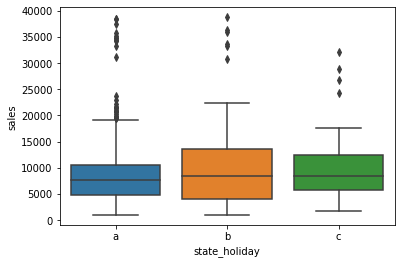

In [15]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

#plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

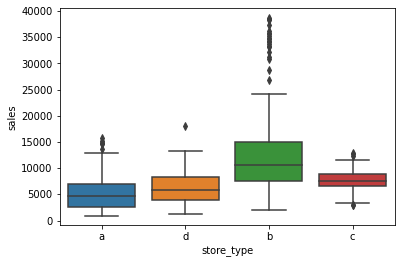

In [16]:
sns.boxplot(x='store_type', y='sales', data=aux1)

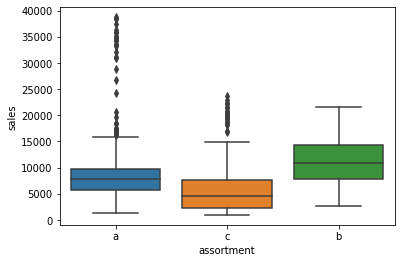

In [17]:
sns.boxplot(x='assortment', y='sales', data=aux1)

# 2.0 Feature Engineering

In [18]:
df2 = df1.copy()

## 2.1 Mind Map Hypothesis

In [19]:
Image('img\MindMapHypothesis.png')


## 2.2 Hypothesis Creation

### 2.1.1 Store Hypothesis 

**1.** Lojas com maior número de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com mais competidores deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vender mais.

### 2.1.2 Product Hypothesis

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas com maior exposição do produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**4.** Lojas com descontos maiores deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com promoções mais longas deveriam vender mais.

**7.** Lojas com promoções consecutivas deveriam vender mais.

### 2.1.3 Time Hypothesis

**1.** Lojas abertas durante o Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo do ano.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.2 Final Hypothesis

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com mais competidores deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com promoções mais longas deveriam vender mais.

**6.** Lojas com promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo do ano.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Feature Engineering

In [20]:
#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week_of_year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

#year_week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#competition_since
df2['competition_since'] = df2.apply(lambda x: datetime(year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1),axis=1)
df2['competition_time_month'] = ((df2['date']-df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

#promo_since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.strptime(x + '-1', '%Y-%W-%w')- timedelta(days=7))
df2['promo_time_week'] = ((df2['date']-df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

#state_holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# 3.0 Filtering Variables

In [21]:
df3 = df2.copy()

## 3.1 Filtering lines

In [22]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Filtering cols

In [23]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0 Exploratory Data Analysis

In [24]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response variable

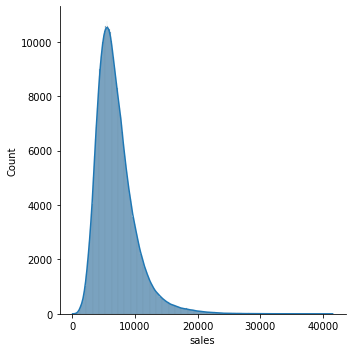

In [25]:
sns.displot(df4['sales'], kde=True)

### 4.1.2 Numeric variable

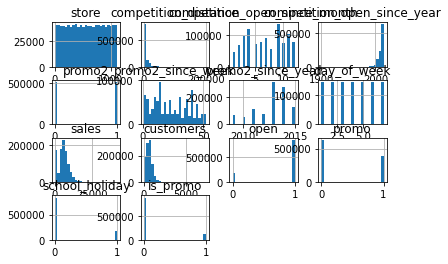

In [26]:
num_attributes.hist(bins=25);

### 4.1.3 Categorical variable

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


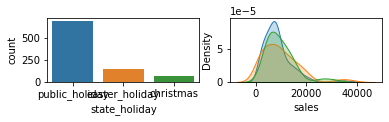

In [27]:
#state_holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


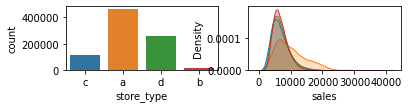

In [28]:
#store_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


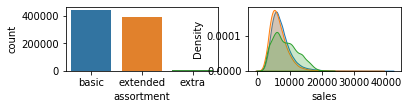

In [29]:
#assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)

## 4.2 Bivariate Analysis

### H1. Lojas com maior sortimento deveriam vender mais.
FALSO com lojas mais sortimento vendem menos

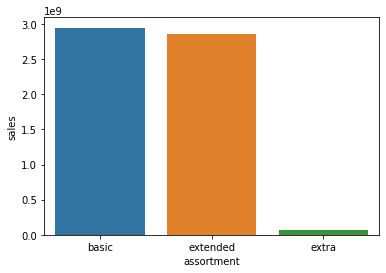

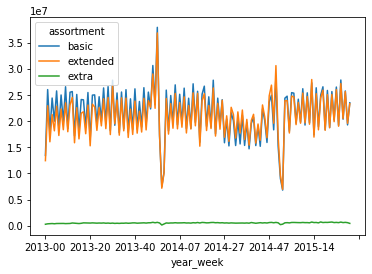

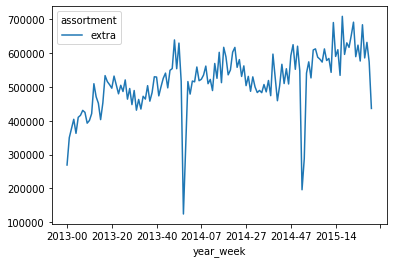

In [30]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week',columns='assortment',values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week',columns='assortment',values='sales').plot()

### H2. Lojas com mais competidores deveriam vender menos.
FALSO lojas com mais competidores vendem mais

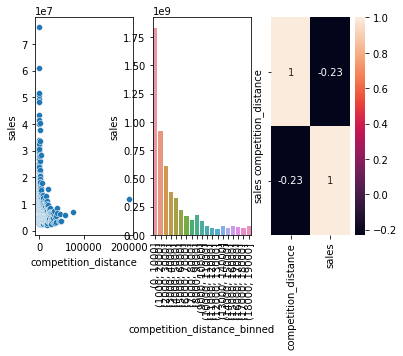

In [31]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1, 3, 3)
x = sns.heatmap(aux1.corr(method='pearson'), annot=True);
bottom, top = x.get_ylim()
#x.set_xlim(bottom+0.5, top-0.5)

### H3. Lojas com competidores à mais tempo deveriam vender mais.
FALSO lojas com competidores a mais tempo vendem mais

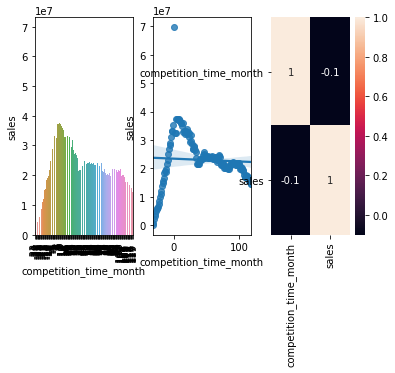

In [32]:
plt.subplot (1, 3, 1)
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2)
plt.xticks(rotation=90);

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2)

plt.subplot(1, 3, 3)
x = sns.heatmap(aux1.corr(method='pearson'), annot=True);
bottom, top = x.get_ylim()

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
FALSO lojas com promoções extendidas vendem menos, depois de algum tempo

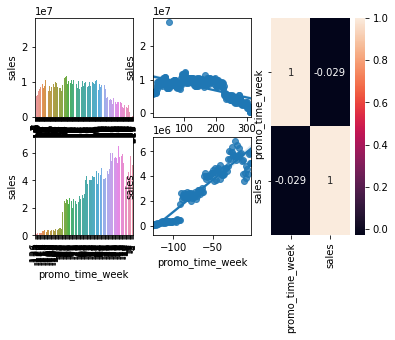

In [33]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

grid = gs.GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] #promo extendida
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2)

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] #promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### <s> H5. Lojas com promoções mais longas deveriam vender mais. </s>

### H6. Lojas com promoções consecutivas deveriam vender mais.
FALSO lojas com promoções consecutivas vendem menos

In [34]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


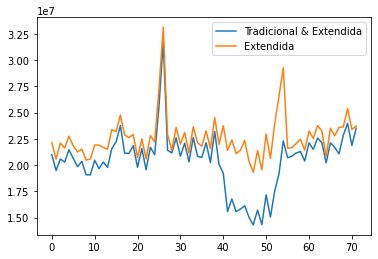

In [35]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional & Extendida','Extendida']);

### H7. Lojas abertas durante o Natal deveriam vender mais.
FALSO lojas que abrem no natal vendem menos

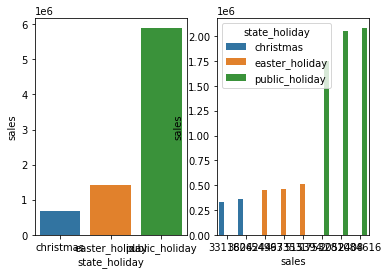

In [36]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1,2,2)
aux2 = aux[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='sales', y='sales', hue='state_holiday', data=aux2);

### H8. Lojas deveriam vender mais ao longo do ano.
FALSO lojas vendem menos durante os anos

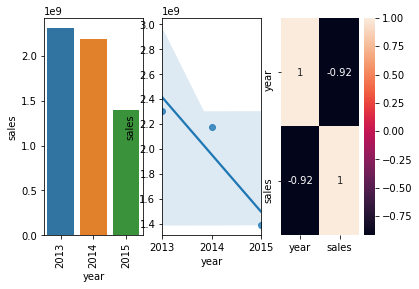

In [37]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1);
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H9. Lojas deveriam vender mais no segundo semestre do ano.
FALSO lojas vendem menos no segundo semestre

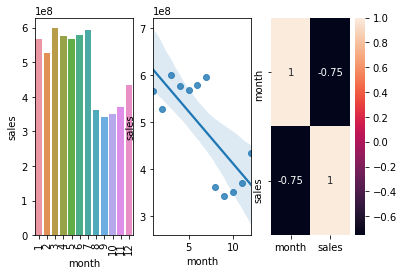

In [38]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux1);
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.
VERDADEIRO lojas vendem mais depois do dia 10

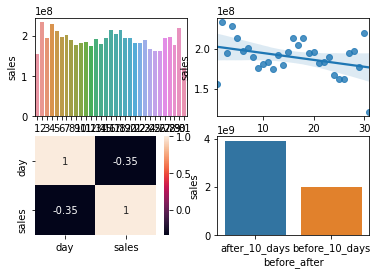

In [39]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1);
#plt.xticks(rotation=90);

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after', y='sales', data=aux2);

### H11. Lojas deveriam vender menos aos finais de semana.
VERDADEIRO lojas vendem menos aos finais de semana

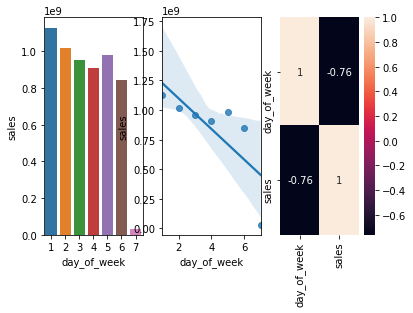

In [40]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1);
#plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H12. Lojas deveriam vender menos durante os feriados escolares.
VERDADEIRO lojas vendem menos durante os feriados escolares, exceto julho e agosto

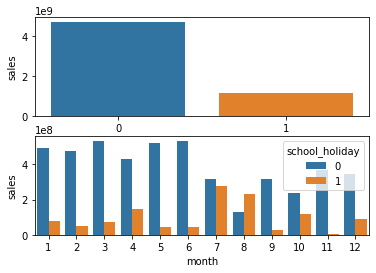

In [41]:
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux1);

aux2 = df4[['month', 'school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

### 4.2.1 Resumo

In [42]:
tab = [['Hipoteses', 'Conclusão', 'Relevância'], 
       ['H1', 'Falsa', 'Baixa'],
       ['H2', 'Falsa', 'Média'],
       ['H3', 'Falsa', 'Média'],
       ['H4', 'Falsa', 'Baixa'],
       ['H5', '-', '-'],
       ['H6', 'Falsa', 'Baixa'],
       ['H7', 'Falsa', 'Média'],
       ['H8', 'Falsa', 'Alta'],
       ['H9', 'Falsa', 'Alta'],
       ['H10', 'Verdadeira', 'Alta'],
       ['H11', 'Verdadeira', 'Alta'],
       ['H12', 'Verdadeira', 'Baixa']]

print(tabulate(tab, headers='firstrow'))

Hipoteses    Conclusão    Relevância
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Média
H3           Falsa        Média
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Média
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attributes

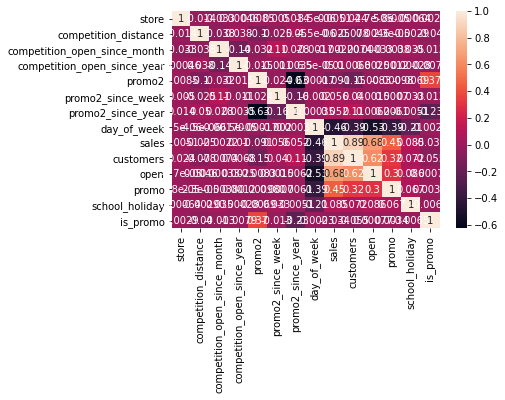

In [43]:
correlations = num_attributes.corr(method='pearson')
sns.heatmap(correlations,annot=True);

### 4.3.2 Categorical Attributes

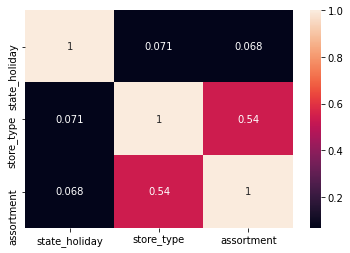

In [44]:
#only categorical data
a = df4.select_dtypes(include='object')

#calculate cramer v
a1 = cramer_v (a['state_holiday'], a['state_holiday'])
a2 = cramer_v (a['state_holiday'], a['store_type'])
a3 = cramer_v (a['state_holiday'], a['assortment'])

a4 = cramer_v (a['store_type'], a['state_holiday'])
a5 = cramer_v (a['store_type'], a['store_type'])
a6 = cramer_v (a['store_type'], a['assortment'])

a7 = cramer_v (a['assortment'], a['state_holiday'])
a8 = cramer_v (a['assortment'], a['store_type'])
a9 = cramer_v (a['assortment'], a['assortment'])

#finald ataset
d = pd.DataFrame({'state_holiday': [a1,a2,a3],
                 'store_type': [a4,a5,a6],
                 'assortment': [a7,a8,a9]})
d = d.set_index(d.columns)

#heat map
sns.heatmap(d,annot=True)

# 5.0 Data Preparation

In [45]:
df5 = df4.copy()

## 5.1 Normalização

**Não tem variável com distribuição normal**

## 5.2 Rescaling

In [46]:
#a = df5.select_dtypes(include=['float64','int64'])

rs = RobustScaler()
mms = MinMaxScaler()

#competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

#competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

#promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

#year
df5['year'] = mms.fit_transform(df5[['year']].values)

## 5.3 Transformação

### 5.3.1 Encoding

In [47]:
#state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5,prefix=['state_holiday'], columns=['state_holiday'])

#store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

#assortment - Ordinal Encoding
assortment_dict = {'basic':1, 'extra':2, 'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Response Variable Transformation

In [48]:
df5['sales'] = np.log(df5['sales'])

### 5.3.3 Nature Transformation

In [49]:
#day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2.*np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2.*np.pi/7)))

#month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2.*np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2.*np.pi/12)))

#day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2.*np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2.*np.pi/30)))

#week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2.*np.pi/52)))

# 6.0 Feature Selection

In [50]:
df6 = df5.copy()

## 6.1 Split Dataframe into test and training dataset

In [51]:
cols_drop = ['week_of_year','day','month','day_of_week','promo_since','competition_since','year_week']
df6 = df6.drop(cols_drop,axis=1)

#training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

#test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}\n'.format(X_train['date'].max()))

print('Test Min Date: {}'.format(X_test['date'].min()))
print('Test Max Date: {}'.format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2 Boruta as feature selector

In [52]:
#training and test dataset for Boruta
x_train_n = X_train.drop(['date','sales'],axis=1).values
y_train_n = y_train.values.ravel()

#define RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)

#define Boruta
#boruta = BorutaPy(rf, n_estimators='auto',verbose=2,random_state=42).fit(x_train_n,y_train_n)

### 6.2.1 Best feature from Boruta

In [53]:
#cols_selected = boruta.support_.tolist()

#best feature
#x_train_fs = x_train.drop(['date','sales'],axis=1)
#cols_selected_boruta = x_train_fs.iloc[:,cols_selected].columns.to_list()
#cols_selected_boruta

#not selected from Boruta
#cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns,cols_selected_boruta))
#cols_not_selected_boruta

## 6.3 Manual Feature Selection

In [54]:
cols_selected_boruta = ['store','promo','store_type','assortment','competition_distance','competition_open_since_month',
                        'competition_open_since_year','promo2','promo2_since_week','promo2_since_year','competition_time_month',
                        'promo_time_week','day_of_week_sin','day_of_week_cos','month_sin','month_cos','day_sin','day_cos',
                        'week_of_year_sin','week_of_year_cos']

#columns to add
feat_to_add = ['date','sales']

#final feature
#cols_selected_boruta.extend(feat_to_add)

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7.0 Machine Learning Modeling

In [55]:
x_train = X_train[cols_selected_boruta]
x_test = X_test [cols_selected_boruta]

#time series data preparation
x_training = X_train[cols_selected_boruta_full]

## 7.1 Average Model

In [56]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#prediction
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})
aux1 = pd.merge(aux1,aux2,how='left',on='store')
yhat_baseline = aux1['predictions']

#performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800167,0.413085,1835.141019


## 7.2 Linear Regression Model

In [57]:
#model
lr = LinearRegression().fit(x_train,y_train)

#prediction
yhat_lr = lr.predict(x_test)

#performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.086951,0.292756,2671.056821


### 7.2.1 Linear Regression Model

In [58]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,MAE CV,MAPE CV,RMSE CV
0,1980.05 +/- 0.0,0.28 +/- 0.0,2840.02 +/- 0.0


## 7.3 Linear Regression Regularized Model - Lasso

In [59]:
#model
lrr = Lasso(alpha = 0.01).fit(x_train,y_train)

#prediction
yhat_lrr = lrr.predict(x_test)

#performance
lrr_result = ml_error('Linear Regression Regularized', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression Regularized,1891.702084,0.289165,2744.462517


### 7.3.1 Lasso - Cross Validation

In [60]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

,MAE CV,MAPE CV,RMSE CV
0,2014.54 +/- 0.0,0.28 +/- 0.0,2918.84 +/- 0.0


## 7.4 Random Forest Regressor

In [61]:
#model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1,random_state=42).fit(x_train,y_train)

#prediction
yhat_rf = rf.predict(x_test)

#performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,687.318371,0.101078,1021.03838


### 7.4.1 Random Forest Regressor - Cross Validation

In [62]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest', rf, verbose=True)
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,MAE CV,MAPE CV,RMSE CV
0,697.08 +/- 0.0,0.1 +/- 0.0,1004.43 +/- 0.0


## 7.5 XGBoost

In [63]:
#model
model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
                            n_estimators=100,
                            eta=0.01,
                            max_depth=10,
                            subsample=0.7,
                            colsample_bytee=0.9).fit(x_train,y_train)

#prediction
yhat_xgb = model_xgb.predict(x_test)

#performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,864.410771,0.124925,1271.519798


### 7.5.1 XGBoost - Cross Validation

In [66]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost', model_xgb, verbose=True)
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,MAE CV,MAPE CV,RMSE CV
0,1022.52 +/- 156.61,0.14 +/- 0.02,1474.96 +/- 216.05


## 7.6 Compare Model's Performance

### 7.6.1 Single Performance

In [64]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,687.318371,0.101078,1021.038380
0,XGBoost Regressor,864.410771,0.124925,1271.519798
0,Average Model,1354.800167,0.413085,1835.141019
0,Linear Regression,1867.086951,0.292756,2671.056821
0,Linear Regression Regularized,1891.702084,0.289165,2744.462517


### 7.6.2 Real Performance - Cross Validation

In [ ]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv.sort_values('RMSE')